# Exploratory Data Analysis
**Questions to Explore:**
* How is the response variable distributed?
* What conference has the strongest homefield advantage?

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (11,7)
sns.set_palette("crest_r")

In [2]:
cfb_data = pd.read_csv('data/cfb_final.csv')
cfb_data

,id,home_team,season,conference_home,firstDowns_home,fourthDownConversions_home,fourthDowns_home,fumblesLost_home,fumblesRecovered_home,games_home,...,rushingYards_away,sacks_away,tacklesForLoss_away,thirdDownConversions_away,thirdDowns_away,avgYards_away,turnovers_away,talent_away,totalPPA_away,winner
0,400787117,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,182.923077,0.000000,0.000000,6.769231,14.076923,404.615385,1.307692,379.60,251.8,H
1,400787254,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,173.416667,0.000000,0.000000,4.333333,13.000000,360.666667,1.750000,314.72,110.4,H
2,400787266,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,136.833333,0.000000,0.000000,5.750000,15.416667,315.166667,1.916667,402.58,111.7,H
3,400760497,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,244.250000,0.000000,0.000000,5.833333,13.333333,338.250000,1.833333,186.45,53.6,H
4,400787280,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,165.076923,0.000000,0.000000,5.076923,14.461538,370.615385,1.846154,331.44,127.3,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4109,401269384,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,192.857143,1.142857,2.142857,5.857143,12.285714,392.000000,1.000000,594.70,374.7,H
4110,401247338,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,109.375000,3.125000,5.875000,5.500000,14.250000,360.750000,1.375000,611.17,249.4,A
4111,401247297,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,194.875000,2.250000,5.625000,5.375000,14.250000,347.750000,1.125000,644.09,202.5,H
4112,401249035,Wyoming,2020.0,Mountain West,18.500000,1.000000,2.000000,0.666667,1.000000,6.0,...,105.857143,2.571429,7.285714,6.000000,13.714286,347.714286,1.000000,571.21,321.2,A


## Topic 0: Response Variable Distribution

Since the `winner` column is our target variable, we should see if the classes are imbalanced and if so, to what extent. That can alter what models we'll build or how we evaluate them.

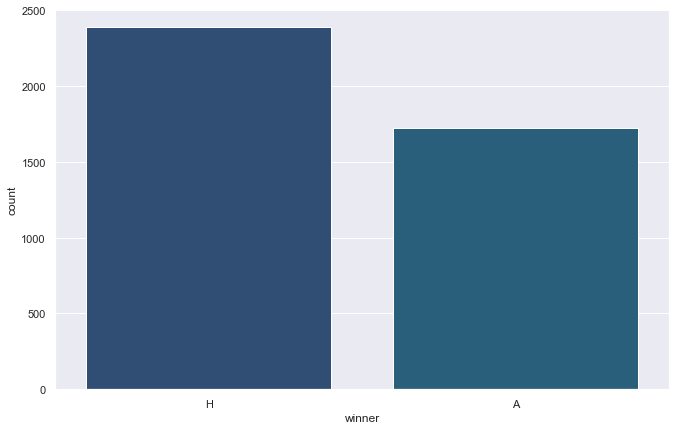

In [30]:
sns.countplot(data=cfb_data, x='winner')

In [18]:
cfb_data['winner'].value_counts()

H    2390
A    1724
Name: winner, dtype: int64

Our classes are split approximately 2400/1700 home/away. Since the data shows a 60/40 balance of classes, there shouldn't be too much cause for concern or attention. In other words, we won't have to evaluate our model with metrics like [cohen's kappa](https://www.knime.com/blog/cohens-kappa-an-overview), for example. We'll likely stick with the ROC AUC metric.

## Topic 1: What conference has the strongest home-field advantage?

I want to create a side-by-side countplot, ordered by number of times each conference has won as the home team. We can create a crosstab, sort the values by the 'H' column, and get the index. This can then be passed to the `order` parameter in `sns.countplot`.

We'll quantify home-field advantage by subtracting the number of away wins from home wins for each conference, then scale for number of games played.

In [19]:
cross_tab = pd.crosstab(cfb_data['conference_home'], cfb_data['winner'], margins=True).sort_values('H')
# .index[:-1] is added to exclude a blank 'All' column
cross = cross_tab.index[:-1]
cross_tab

winner,A,H,All
conference_home,,,
FBS Independents,45,88,133
Sun Belt,144,159,303
Mid-American,172,165,337
Conference USA,185,197,382
Big 12,143,201,344
Mountain West,155,202,357
American Athletic,148,228,376
Pac-12,139,248,387
ACC,195,271,466


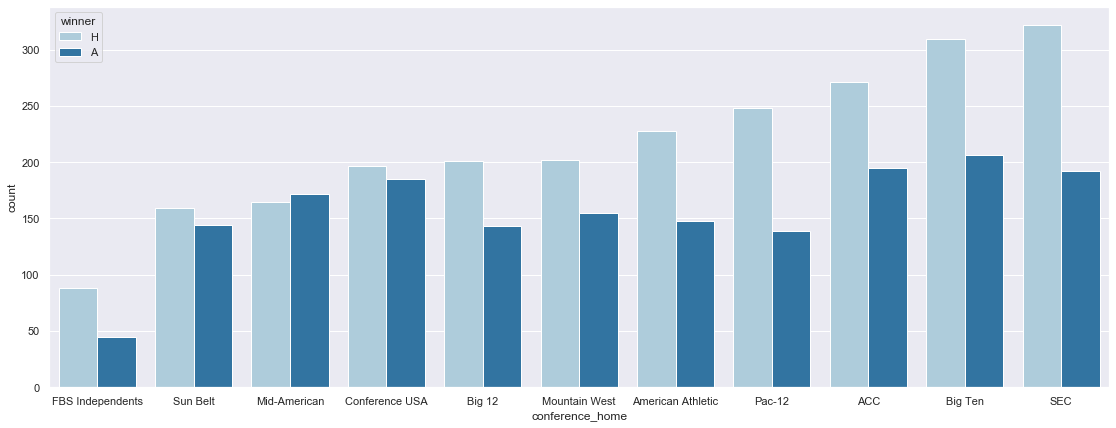

In [32]:
plt.figure(figsize=(19,7))
sns.countplot(data=cfb_data, x='conference_home', hue='winner', palette='Paired', order=cross)

It seems that the SEC has the largest difference in games won as the home team vs games lost as the home team, perhaps followed by FBS Independents or the Pac-12. Let's calculate the difference in these values, scale it by the number of games played, and visualize who has the largest home field advantage.

In [34]:
cross_tab['scaled_diff'] = (cross_tab['H'] - cross_tab['A']) / cross_tab['All']
cross_tab = cross_tab.sort_values('scaled_diff', ascending=False)
cross_tab = cross_tab.reset_index()
cross_tab.columns

Index(['conference_home', 'A', 'H', 'All', 'scaled_diff'], dtype='object', name='winner')

In [35]:
cross_tab

winner,conference_home,A,H,All,scaled_diff
0,FBS Independents,45,88,133,0.323308
1,Pac-12,139,248,387,0.281654
2,SEC,192,322,514,0.252918
3,American Athletic,148,228,376,0.212766
4,Big Ten,206,309,515,0.200000
5,Big 12,143,201,344,0.168605
6,ACC,195,271,466,0.163090
7,All,1724,2390,4114,0.161886
8,Mountain West,155,202,357,0.131653
9,Sun Belt,144,159,303,0.049505


[Text(0, 0.5, 'Scaled Difference'),
 Text(0.5, 0, 'Home Conference'),
 Text(0.5, 1.0, 'Home Field Advantage')]

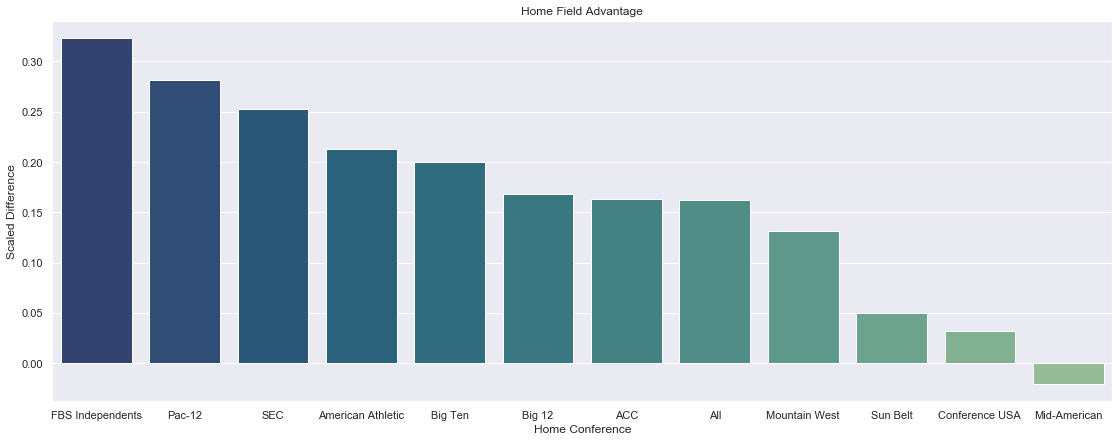

In [38]:
plt.figure(figsize=(19,7))
ax = sns.barplot(data=cross_tab, x='conference_home', y='scaled_diff', palette='crest_r')
ax.set(xlabel='Home Conference', ylabel='Scaled Difference', title='Home Field Advantage')

Here we can see that accounting for the number of games played, the 3 conferences with the strongest home-field advantage are FBS Independents (Notre Dame, BYU, Army, etc), the Pac-12 (Stanford, UCLA, USC, etc), and the SEC (Alabama, Georgia, Florida, etc), respectively.

The conference with the weakest home field advantage is the Mid-American conference (Toledo, Ohio, Bowling Green, etc), coming in at -0.02. In other words, there is virtually no home field advantage since 2015 and potentially even a home field ***dis***advantage.

The value for all teams is approximately 0.16. In other words, when scaling for the number of games played, home teams win 0.16 more games than the away team.